# Cinestill 800T

Notebook for extracting film pigment and experimenting with layers to get the right balancing.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski

## Load film image

In [2]:
film_image = "Films/CINESTILL_800T.png"

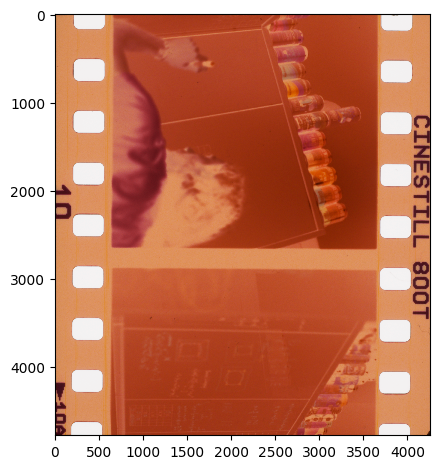

In [3]:
image = ski.util.img_as_float64(ski.io.imread(film_image))
ski.io.imshow(image)

## Film Pigment

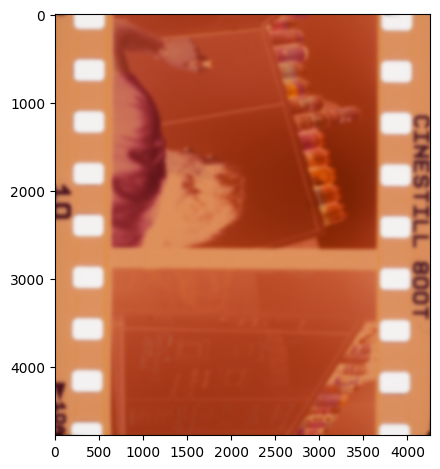

In [21]:
blurred = ski.filters.gaussian(image, sigma=(20, 20), channel_axis=-1)
ski.io.imshow(blurred)

### Obtain colour distribution

In [22]:
distribution, edges = np.histogramdd(blurred.reshape(-1, 3), bins=256, range=[(0,1), (0,1), (0, 1)],)

In [23]:
LIMIT_COLOURS = 50

sorted_count = np.sort(distribution, axis=None)[-LIMIT_COLOURS:]
indices = np.argsort(distribution, axis=None)[-LIMIT_COLOURS:]

sorted_colours = np.array(np.unravel_index(indices, shape=distribution.shape)).T
by_intensity = np.linalg.norm(sorted_colours, axis=1).argsort()

sorted_count_by_intensity = sorted_count[by_intensity]
sorted_colours_by_intensity = sorted_colours[by_intensity]

### Select `white` and `emulsion` colours

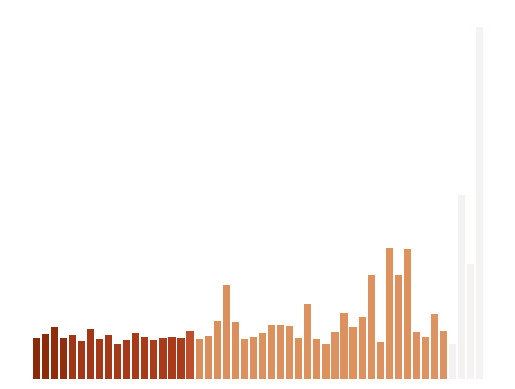

In [24]:
plt.bar(np.arange(LIMIT_COLOURS) + 1, sorted_count_by_intensity[-LIMIT_COLOURS:], color=sorted_colours_by_intensity[-LIMIT_COLOURS:] / 255)
plt.axis("off")
plt.show()

In [27]:
white = sorted_colours_by_intensity[-1]
emulsion = sorted_colours_by_intensity[-18]

print(f"White value: {tuple(white.tolist())}")
print(f"Emulsion value: {tuple(emulsion.tolist())}")

White value: (245, 242, 242)
Emulsion value: (221, 145, 93)


### Preprocess `emulsion` to get pigment

In [29]:
white_balanced_emulsion = (emulsion * 255 / white).astype(np.uint8)

# Set to maximum lightness
hsv = ski.color.rgb2hsv(np.array([[white_balanced_emulsion]]))
hsv[..., -1] = 1


pigment = (ski.color.hsv2rgb(hsv).squeeze() * 255).astype(np.uint8)

print(f"Pigment value: {tuple(pigment.tolist())}")


Pigment value: (255, 168, 107)


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

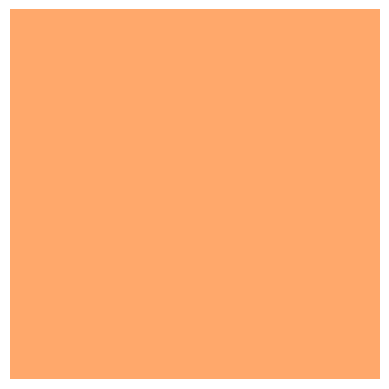

In [34]:
pigment_image = np.empty((256, 256, 3), dtype=np.uint8)
pigment_image[:, :] = pigment

plt.imshow(pigment_image)
plt.axis("off")

## Layers

In [1]:
from pathlib import Path
from nevernegative.layers.utils.resize import Resize
from nevernegative.scanner.simple import SimpleScanner
import matplotlib.pyplot as plt

In [2]:
images_folder = "/Users/louismanestar/Documents/Projects/Film Scanner/nevernegative/images/Liverpool"
glob = "*.NEF"

### V1: Constrast Stretching

In [3]:
from nevernegative.layers.balancing.brightness import Brightness
from nevernegative.layers.balancing.contrast import Contrast
from nevernegative.layers.balancing.gamma import Gamma
from nevernegative.layers.balancing.contrast_stretch import ContrastStretch
from nevernegative.layers.balancing.pigment import RemoveEmulsionPigment
from nevernegative.layers.balancing.saturation import Saturation
from nevernegative.layers.balancing.temperature import Temperature
from nevernegative.layers.utils.clip import Clip
from nevernegative.layers.balancing.invert import Invert
from nevernegative.layers.metrics.noise import EstimateNoise

layers = [
    Invert(),
    ContrastStretch((0.01, 0.99), per_channel=True, mode="mean"),
    Gamma(1.3, channel=2),
    Clip(),
]

### V2: Shift-matching

In [3]:
from nevernegative.layers.balancing.gamma import Gamma
from nevernegative.layers.balancing.match_means import MatchMeans
from nevernegative.layers.balancing.shift import ShiftBound
from nevernegative.layers.balancing.invert import Invert

layers = [
    Invert(),
    MatchMeans(0, 1),
    MatchMeans(2, 1),
    ShiftBound(0.01, value=0.05),
    Gamma(0.9),
]

### V3: Emulsion pigment

In [10]:
from nevernegative.layers.balancing.brightness import Brightness
from nevernegative.layers.balancing.gamma import Gamma
from nevernegative.layers.balancing.contrast import Contrast
from nevernegative.layers.balancing.pigment import RemoveEmulsionPigment
from nevernegative.layers.balancing.shift import ShiftBound
from nevernegative.layers.balancing.invert import Invert

layers = [
    # Temperature(temperature=5200),
    RemoveEmulsionPigment(pigment=(221, 145, 93)),
    Invert(),
    Brightness(0.78, channel=0),
    Brightness(0.54, channel=1),
    Brightness(0.45, channel=2),
    ShiftBound(0.01, value=0.05),
    Gamma(0.9),
    # Contrast(1.2),
    # Brightness(1.2)
]

### V4: Linearly removing pigment

In [6]:
from nevernegative.layers.balancing.brightness import Brightness
from nevernegative.layers.balancing.contrast import Contrast
from nevernegative.layers.balancing.gamma import Gamma
from nevernegative.layers.balancing.invert import Invert

layers = [
    Brightness(-0.45, channel=0, mode="sum"),
    Brightness(0, channel=1, mode="sum"),
    Brightness(0.22, channel=2, mode="sum"),
    Invert(),
    Brightness(0.5),
    Contrast(2.75),
]

### Single Image

(np.float64(-0.5), np.float64(598.5), np.float64(399.5), np.float64(-0.5))

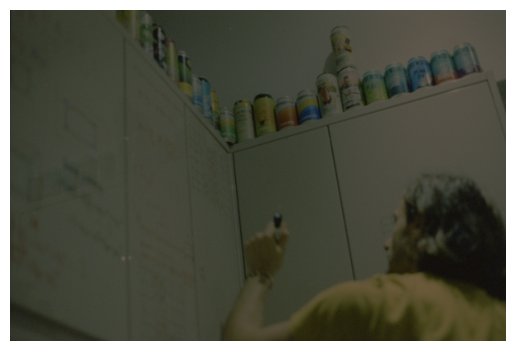

In [11]:
scanner = SimpleScanner([Resize(height=400), *layers], device="mps")

filename = "DSC_1055.NEF"
output_path = Path("results/cinestill/")

processed = scanner.file(
    source=Path(images_folder) / filename,
    destination=Path("results/cinestill/"),
    is_raw=True,
    plot_path=output_path
)

plt.imshow(processed.permute(1, 2, 0).cpu().numpy())
plt.axis("off")

In [ ]:
scanner = SimpleScanner(layers, device="mps")

scanner.glob(
    source=(Path(images_folder) / glob).as_posix(),
    destination=Path("test_images/cinestill"),
    is_raw=True,
)

Proccesing images: 100%|██████████| 37/37 [15:38<00:00, 25.36s/it]


: 